# Generación de Spark Dataframe
Con este script se copian los datos input del modelo al bucket del storage.



In [1]:
#from __future__ import absolute_import
import sys

os.environ['PYSPARK_SUBMIT_ARGS'] = '--name "rec_cuenta" --master yarn --conf spark.executor.memory=3G --conf spark.executor.cores=1 --conf spark.executor.instances=32 pyspark-shell' 

#!{sys.executable} -m pip install --upgrade pip
#!{sys.executable} -m pip install py4j==0.10.7 --force-reinstall
#!{sys.executable} -m pip install numpy==1.15.4
#!{sys.executable} -m pip install pandas==0.24.1
#!{sys.executable} -m pip install pandas-gbq==0.9.0
#!{sys.executable} -m pip install google-cloud-bigquery==1.9.0
#!{sys.executable} -m pip install google-cloud-storage==1.14.0
#!{sys.executable} -m pip freeze
#!{sys.executable} -m pip install seaborn
#!{sys.executable} -m pip install tensorflow
#!{sys.executable} -m pip install google
#!{sys.executable} -m pip install datalab
#!{sys.executable} -m pip install pyspark


In [2]:
import numpy as np
import tensorflow as tf
import shutil
import io
import pandas as pd
from pyspark.sql.functions import explode, col, log, collect_list, collect_set, udf, array, size
from pyspark.sql.types import ArrayType, FloatType,StringType, IntegerType, StructType, StructField
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql import Row
import datetime


## Parámetros a incluir

In [3]:
## Parámetros a tener en cuenta en DEV

training_split =0.8
testing_split = 0.1
eval_split= 0.1
eval_split

0.1

## Creación de rutas para leer datos, guardar diccionarios y outputs binarios



In [4]:
# reading from bucket
# paramétros de modelo productivo
bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket')
print(bucket)
#today_date= now.strftime("%Y_%m_%d_%H_%M_%S")
todays_date = '2019_02_18_13_39_11' 
bucket_name = "datasets_prueba"
datafr_name = "local"
bucket_path = "gs://{}/{}/{}/{}".format(bucket, bucket_name, datafr_name, todays_date)
print(bucket_path)


pry_spsa
gs://pry_spsa/datasets_prueba/local/2019_02_18_13_39_11


In [5]:
# Ruta para guardar los diccionarios generados

bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket')
bucket_name_subfolder = "research"
datafr_name = "codigo_cuenta_rec"
type_data = "diccionario_usr"
bucket_path_diccionario_userId = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name, type_data)

type_data = "diccionario_item"
bucket_path_diccionario_itemId = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name, type_data)

print(bucket_path_diccionario_itemId)


gs://pry_spsa/research/codigo_cuenta_rec/diccionario_item/


In [6]:
# guardamos nuestros ratings en la carpeta 

training_folder_name="training_binario"
testing_folder_name="testing_binario"
eval_folder_name="eval_binario"

bucket_path_rating_training_binario = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,training_folder_name)
bucket_path_rating_testing_binario = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,testing_folder_name)
bucket_path_rating_eval_binario = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,eval_folder_name)

print(bucket_path_rating_training_binario)
print(bucket_path_rating_testing_binario)
print(bucket_path_rating_eval_binario)




gs://pry_spsa/research/codigo_cuenta_rec/training_binario/
gs://pry_spsa/research/codigo_cuenta_rec/testing_binario/
gs://pry_spsa/research/codigo_cuenta_rec/eval_binario/


In [7]:
### DESCOMENTAR LA SIGUIENTE LÍNEA PARA PASO A PRODUCCIÓN ###


#sc


sc.getConf().toDebugString()

'spark.app.id=application_1551903967241_0151\nspark.app.name=pyspark-shell\nspark.driver.appUIAddress=http://dprc-mkt-tensorflow-tony-jupyter-m.c.sistemas-bi.internal:4040\nspark.driver.extraJavaOptions=-Dflogger.backend_factory=com.google.cloud.hadoop.repackaged.gcs.com.google.common.flogger.backend.log4j.Log4jBackendFactory#getInstance\nspark.driver.host=dprc-mkt-tensorflow-tony-jupyter-m.c.sistemas-bi.internal\nspark.driver.maxResultSize=1920m\nspark.driver.memory=3840m\nspark.driver.port=36469\nspark.dynamicAllocation.enabled=true\nspark.dynamicAllocation.maxExecutors=10000\nspark.dynamicAllocation.minExecutors=1\nspark.eventLog.dir=hdfs://dprc-mkt-tensorflow-tony-jupyter-m/user/spark/eventlog\nspark.eventLog.enabled=true\nspark.executor.cores=1\nspark.executor.extraJavaOptions=-Dflogger.backend_factory=com.google.cloud.hadoop.repackaged.gcs.com.google.common.flogger.backend.log4j.Log4jBackendFactory#getInstance\nspark.executor.id=driver\nspark.executor.instances=32\nspark.executor

## Leyendo data desde la carpeta local

In [8]:
bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket')
print(bucket)

#project = sc._jsc.hadoopConfiguration().get('fs.gs.project.id')
#print(project)
    
#todays_date = datetime.strftime(datetime.today(), "%Y_%m_%d_%H_%M_%S")
#input_directory = "gs://{}/tmp/spsa-{}".format(bucket, todays_date)
#input_directory = "gs://{}/datasets_prueba/".format(bucket)
#print(input_directory)


pry_spsa


## Recuperación de Datos Spark

In [9]:
parquet_files = "{}/part-*.snappy.parquet".format(bucket_path)
print(parquet_files)

sdf = spark.read.parquet(parquet_files)
#sdf.cache()
# creamos View para poder trabajar usando SQL con spark y filtramos los casos en que el codigo cuenta tenga menos de 5 items
sdf.createOrReplaceTempView("sdf")

gs://pry_spsa/datasets_prueba/local/2019_02_18_13_39_11/part-*.snappy.parquet


In [10]:
#sdf.show(1)
# PREGUNTARLE A EDU QUE PASA CON LAS SUBFAMILIAS
sdf.columns

['anio_calendario',
 'categoria',
 'cluster',
 'codigo_cuenta',
 'codigo_producto',
 'costo_kardex',
 'margen',
 'monto_dscto_producto',
 'nro_dia_anio',
 'nro_dia_mes',
 'nro_mes_anio',
 'nro_semana_anio',
 'seccion_dia_compra',
 'semestre_calendario',
 'trimestre_calendario',
 'venta_bruta',
 'venta_neta',
 'venta_total',
 'venta_unidad']

## Creación de Rating Continuo

#### Crearemos un rating continuo el cual después lo volveremos binario para usarlo en el proceso de Validación Cruzada


In [11]:


#query_cod_cuentas='''Select  distinct codigo_cuenta from sdf ''' 

cod_cuenta=spark.sql('''Select  distinct codigo_cuenta from sdf ''' )
cod_producto=spark.sql('''Select  distinct codigo_producto from sdf ''' )

#codigos de testeo que se usaran como keys para predecir

#cod_cuenta=spark.sql('''Select distinct codigo_cuenta from eval_cod_cuenta''')
#cod_cuenta.write.mode("overwrite").format('csv').save('gs://pry_spsa/datasets_prueba/cod_cuenta/',header = 'true')


train_cod_cuenta, test_cod_cuenta, eval_cod_cuenta= cod_cuenta.randomSplit([training_split,testing_split,eval_split], 625) 
#490373 unicos codigo_cuenta

# creamos dos tablas para poder filtrar la data de acuerdo a los codigos cuentas que se haya usado en training y testing 
train_cod_cuenta.createOrReplaceTempView("training_cod_cuenta")
test_cod_cuenta.createOrReplaceTempView("testing_cod_cuenta")
eval_cod_cuenta.createOrReplaceTempView("eval_cod_cuenta")
train_cod_cuenta.show()



+----------------+
|   codigo_cuenta|
+----------------+
|6043566000001780|
|6043566000008942|
|6043566000012605|
|6043566000029922|
|6043566000037909|
|6043566000039582|
|6043566000042602|
|6043566000046082|
|6043566000047460|
|6043566000048674|
|6043566000051645|
|6043566000055471|
|6043566000063632|
|6043566000068276|
|6043566000075271|
|6043566000080982|
|6043566000081394|
|6043566000084950|
|6043566000093506|
|6043566000096111|
+----------------+
only showing top 20 rows



### haciendo el split de los datos

In [12]:
train_cod_cuenta.count()

392406

In [13]:

#https://www.quora.com/How-do-I-build-a-recommendation-system-using-transaction-data-quantity-purchased-sales-How-do-I-convert-the-transaction-table-to-rating-table

sql_training_query='''select a.codigo_cuenta, 
                     a.codigo_producto,
                     round(float(sum(venta_bruta)/avg(total_cod)),3) rating
                     from sdf a
                     inner join (select codigo_cuenta, sum(venta_bruta) total_cod from sdf group by codigo_cuenta) b
                     on a.codigo_cuenta=b.codigo_cuenta
                     where a.codigo_cuenta in (select distinct codigo_cuenta from training_cod_cuenta) 
                     group by a.codigo_cuenta,a.codigo_producto order by codigo_cuenta
'''
# NOTA PASQUI
# cambio para codigo de subfamilia canal offline
# group by a.codigo_cuenta,a.codigo_subfamilia order by codigo_cuenta
# el rating se calcula aca como el porcentaje de las ventas de cada cliente

sql_testing_query='''
                     select a.codigo_cuenta, 
                     a.codigo_producto,
                     round(float(sum(venta_bruta)/avg(total_cod)),3) rating
                     from sdf a
                     inner join (select codigo_cuenta, sum(venta_bruta) total_cod from sdf group by codigo_cuenta) b
                     on a.codigo_cuenta=b.codigo_cuenta
                     where a.codigo_cuenta in (select distinct codigo_cuenta from testing_cod_cuenta) 
                     group by a.codigo_cuenta,a.codigo_producto
'''

sql_eval_query='''select a.codigo_cuenta, 
                  a.codigo_producto,
                  round(float(sum(venta_bruta)/avg(total_cod)),3) rating
                  from sdf a
                  inner join (select codigo_cuenta, sum(venta_bruta) total_cod from sdf group by codigo_cuenta) b
                  on a.codigo_cuenta=b.codigo_cuenta
                  where a.codigo_cuenta in (select distinct codigo_cuenta from testing_cod_cuenta) 
                  group by a.codigo_cuenta,a.codigo_producto
'''


training_df_cod = spark.sql(sql_training_query)
testing_df_cod = spark.sql(sql_testing_query)
eval_df_cod = spark.sql(sql_eval_query)

#training_df_cod=training_df_cod.filter(col('rating')>0)
#testing_df_cod=testing_df_cod .filter(col('rating')>0)
#eval_df_cod=eval_df_cod.filter(col('rating')>0)

## Creacion de tablas para query

training_df_cod.createOrReplaceTempView("training_df_cod")
testing_df_cod.createOrReplaceTempView("testing_df_cod")
eval_df_cod.createOrReplaceTempView("eval_df_cod")

training_df_cod.show(10)


+----------------+---------------+------+
|   codigo_cuenta|codigo_producto|rating|
+----------------+---------------+------+
|6043560006358567|    00000927330| 0.005|
|6043560006358567|    00020098648| 0.004|
|6043560006358567|    00000089201| 0.007|
|6043560006358567|    00000124703| 0.006|
|6043560006358567|    00020112745| 0.032|
|6043560006358567|    00020017639| 0.005|
|6043560006358567|    00000995418| 0.014|
|6043560006358567|    00020092478| 0.004|
|6043560006358567|    00020120179| 0.005|
|6043560006358567|    00000092418| 0.013|
+----------------+---------------+------+
only showing top 10 rows



## Creación de Diccionarios

In [14]:
# Creación de diccionarios de mapeo de codigo_cuenta a userId y de codigo_producto a itemId

#bucket_path_dict_cuenta_userId="gs://pry_spsa/datasets_prueba/diccionario_cuenta_userId"
#bucket_path_dict_producto_itemId="gs://pry_spsa/datasets_prueba/diccionario_producto_userId"

user_mapping=spark.sql('''with cuentas as 
                        (Select  distinct codigo_cuenta from sdf) 
                        select codigo_cuenta, 
                        ROW_NUMBER() OVER(ORDER BY codigo_cuenta asc) userId from cuentas ''' )

item_mapping=spark.sql('''with producto as 
                        (Select  distinct codigo_producto from sdf) 
                        select codigo_producto, 
                        ROW_NUMBER() OVER(ORDER BY codigo_producto asc) itemId from producto ''' )

#Guardamos diccionarios para usarlos
user_mapping.write.mode('overwrite').option("header","true").parquet(bucket_path_diccionario_userId)
item_mapping.write.mode('overwrite').option("header","true").parquet(bucket_path_diccionario_itemId)


# Creamos vista para hacer joins que conviertan de cuenta y producto a userId e itemId


user_mapping.createOrReplaceTempView("user_mapping")
item_mapping.createOrReplaceTempView("item_mapping")

## Usar diccionario de mapeo para convertir codigo cuenta a userId y codigo producto a itemId

In [15]:
## Hacemos el join para poder entrenar con user_id e item_id en vez de codigo_cuenta y codigo_producto

training_join_user_id_item_id='''Select b.userId, c.itemId, a.rating 
                             from training_df_cod a join user_mapping b on a.codigo_cuenta= b.codigo_cuenta 
                             join item_mapping c on a.codigo_producto=c.codigo_producto

'''
testing_join_user_id_item_id='''Select b.userId, c.itemId, a.rating 
                             from testing_df_cod a join user_mapping b on a.codigo_cuenta= b.codigo_cuenta 
                             join item_mapping c on a.codigo_producto=c.codigo_producto

'''
eval_join_user_id_item_id='''Select b.userId, c.itemId, a.rating 
                             from eval_df_cod a join user_mapping  b on a.codigo_cuenta= b.codigo_cuenta 
                             join item_mapping c on a.codigo_producto=c.codigo_producto

'''

training_df= spark.sql(training_join_user_id_item_id)
testing_df= spark.sql(testing_join_user_id_item_id)
eval_df= spark.sql(eval_join_user_id_item_id)

training_df.createOrReplaceTempView("training_df")  
training_df.show(4)


+------+------+------+
|userId|itemId|rating|
+------+------+------+
|229211|   313| 0.002|
|  1445|   313| 0.001|
| 18498|   313| 0.006|
|282132|   313| 0.001|
+------+------+------+
only showing top 4 rows



## Creación de histograma para análisis de raiting Continuo

In [16]:
sdf.schema

StructType(List(StructField(anio_calendario,StringType,true),StructField(categoria,StringType,true),StructField(cluster,StringType,true),StructField(codigo_cuenta,StringType,true),StructField(codigo_producto,StringType,true),StructField(costo_kardex,DoubleType,true),StructField(margen,DoubleType,true),StructField(monto_dscto_producto,DoubleType,true),StructField(nro_dia_anio,StringType,true),StructField(nro_dia_mes,StringType,true),StructField(nro_mes_anio,StringType,true),StructField(nro_semana_anio,StringType,true),StructField(seccion_dia_compra,StringType,true),StructField(semestre_calendario,StringType,true),StructField(trimestre_calendario,StringType,true),StructField(venta_bruta,DoubleType,true),StructField(venta_neta,DoubleType,true),StructField(venta_total,DoubleType,true),StructField(venta_unidad,DoubleType,true)))

In [17]:
query_venta_bruta='''select codigo_cuenta, codigo_producto, 
                     sum(venta_bruta) tot_venta_bruta, 
                     log(sum(venta_bruta)) log_tot_venta_bruta
                     from sdf group by codigo_cuenta, codigo_producto'''

venta_bruta=spark.sql(query_venta_bruta)
venta_bruta.createOrReplaceTempView("venta_bruta")
venta_bruta.show(5)
venta_bruta.schema

+----------------+---------------+------------------+-------------------+
|   codigo_cuenta|codigo_producto|   tot_venta_bruta|log_tot_venta_bruta|
+----------------+---------------+------------------+-------------------+
|6043566000461646|    00020025028|             29.59| 3.3874364664121184|
|6043566000535217|    00000065743|              5.75|  1.749199854809259|
|6043567000215909|    00000831215|2758.7899999999995|  7.922547456786176|
|6043566002574545|    00020120179|               5.5| 1.7047480922384253|
|6043566000612594|    00020082052|             46.53| 3.8400972658565573|
+----------------+---------------+------------------+-------------------+
only showing top 5 rows



StructType(List(StructField(codigo_cuenta,StringType,true),StructField(codigo_producto,StringType,true),StructField(tot_venta_bruta,DoubleType,true),StructField(log_tot_venta_bruta,DoubleType,true)))

In [18]:
## ploteamos las ventas brutas

gre_histogram = venta_bruta.select('tot_venta_bruta').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['tot_venta_bruta', 'frequency']
).set_index(
    'tot_venta_bruta'
).plot(kind='bar')


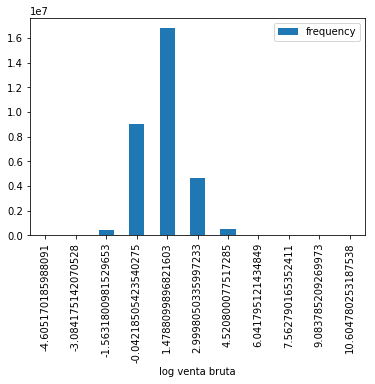

In [19]:
## Ploteamos los logartimos de las ventas

log_histogram = venta_bruta.select('log_tot_venta_bruta').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*log_histogram)), 
    columns=['log venta bruta', 'frequency']
).set_index(
    'log venta bruta'
).plot(kind='bar')

De acuerdo al análisis del logaritmo de la venta bruta los valores cuyo  logaritmo sean menos que cero serán considerados con label 0 y los mayores a 0 con label 1 para asi crear el rating implicito

## creación de rating binario

In [20]:
query_binary_rating='''select codigo_cuenta, codigo_producto, 
                         case when log_tot_venta_bruta > 0 then 1 else 0 end as rating
                         from venta_bruta
                        '''

binary_rating= spark.sql(query_binary_rating)
binary_rating.createOrReplaceTempView("binary_rating")
binary_rating.show()
binary_rating.schema

+----------------+---------------+------+
|   codigo_cuenta|codigo_producto|rating|
+----------------+---------------+------+
|6043566000314183|    00020077070|     1|
|6043566007169846|    00000063609|     1|
|6043566000369427|    00000034464|     1|
|6043566013726324|    00000920012|     1|
|6043566010742027|    00000315845|     1|
|6043566000854535|    00000988350|     1|
|6043566006340612|    00020043780|     1|
|6043566000554077|    01032360001|     1|
|6043566006079657|    00000124903|     1|
|6043566011638422|    00020131734|     1|
|6043566009057072|    00000078343|     1|
|6043566010338768|    00000130990|     1|
|6043566013732918|    00000060769|     1|
|6043566002889778|    00020057414|     1|
|6043566007221332|    00000060769|     1|
|6043566006645754|    00020098818|     1|
|6043566000431268|    00000128186|     1|
|6043566012202418|    00000042345|     1|
|6043566009116118|    00000131594|     1|
|6043566002280218|    00000121747|     1|
+----------------+---------------+

StructType(List(StructField(codigo_cuenta,StringType,true),StructField(codigo_producto,StringType,true),StructField(rating,IntegerType,false)))

In [21]:
## Hacemos el join para poder entrenar con user_id e item_id en vez de codigo_cuenta y codigo_producto

total_join_user_id_item_id='''Select b.userId, c.itemId, a.rating 
                             from binary_rating a join user_mapping b on a.codigo_cuenta= b.codigo_cuenta 
                             join item_mapping c on a.codigo_producto=c.codigo_producto'''

total_binary_df= spark.sql(total_join_user_id_item_id)

total_binary_df.createOrReplaceTempView("total_binary_df")  
total_binary_df.show(4)

+------+------+------+
|userId|itemId|rating|
+------+------+------+
|229211|   313|     1|
|  1445|   313|     1|
| 18498|   313|     1|
|282132|   313|     1|
+------+------+------+
only showing top 4 rows



In [22]:
train_user_binary, test_user_binary, eval_user_binary= total_binary_df.randomSplit([training_split,testing_split,eval_split], 625) #490373 unicos codigo_cuenta

# creamos dos tablas para poder filtrar la data de acuerdo a los codigos cuentas que se haya usado en training y testing 
train_user_binary.createOrReplaceTempView("train_user_binary")
test_user_binary.createOrReplaceTempView("test_user_binary")
eval_user_binary.createOrReplaceTempView("eval_user_binary")


In [23]:

binary_training_query='''select * from total_binary_df
                     where userId in (select distinct userId from train_user_binary) '''

binary_testing_query='''select * from total_binary_df
                     where userId in (select distinct userId from test_user_binary) '''

binary_eval_query='''select * from total_binary_df
                  where userId in (select distinct userId from eval_user_binary)'''


binary_training_df = spark.sql(binary_training_query)
binary_testing_df = spark.sql(binary_testing_query)
binary_eval_df = spark.sql(binary_eval_query)
binary_training_df.show(10)


+------+------+------+
|userId|itemId|rating|
+------+------+------+
|229211|   313|     1|
|  1445|   313|     1|
| 18498|   313|     1|
|282132|   313|     1|
|349741|   313|     1|
|461793|   313|     1|
|258110|   313|     1|
| 65997|   313|     1|
|166476|   313|     1|
|217765|   313|     1|
+------+------+------+
only showing top 10 rows



In [24]:
# guardamos los archivos en formato parquet
binary_training_df.write.mode("overwrite").option("header","true").parquet(bucket_path_rating_training_binario)
binary_testing_df.write.mode("overwrite").option("header","true").parquet(bucket_path_rating_testing_binario)
binary_eval_df.write.mode("overwrite").option("header","true").parquet(bucket_path_rating_eval_binario)
#sdf.unpersist()

In [25]:
binary_training_df.schema

StructType(List(StructField(userId,IntegerType,true),StructField(itemId,IntegerType,true),StructField(rating,IntegerType,false)))